<a href="https://colab.research.google.com/github/chamatt/The-Complete-Self-Driving-Car-Course/blob/master/08%20-%20Traffic%20Sign%20Classification/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [2]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pandas as pd
import pickle
import random

In [0]:
np.random.seed(1)

## Importing German Traffic Signs Dataset

In [6]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

In [9]:
data = pd.read_csv('./german-traffic-signs/signnames.csv')
print(data.head())

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


### Visualizing our dataset

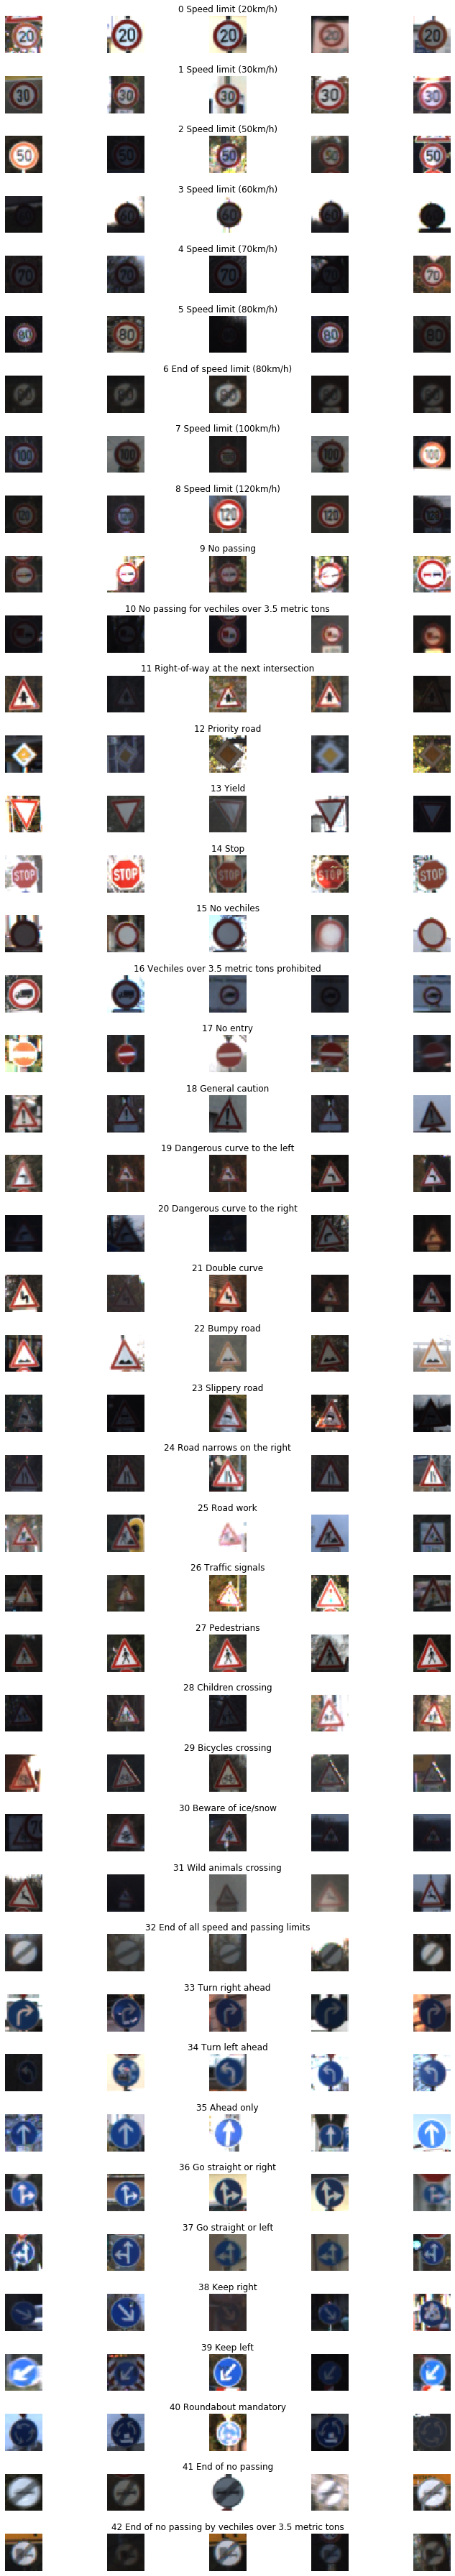

In [10]:
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(10, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " " + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

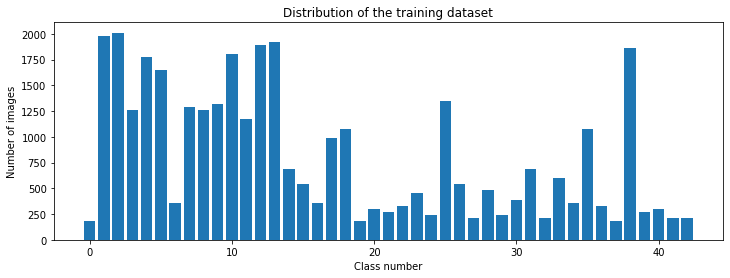

In [11]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

## Image Processing

(32, 32, 3)
36 Go straight or right


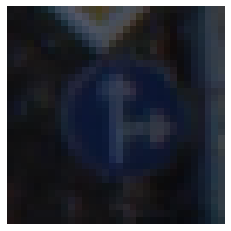

In [12]:
import cv2
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000], data["SignName"][y_train[1000]])

### Grayscaling

(32, 32)


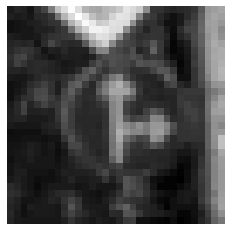

In [13]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  return img

img = grayscale(X_train[1000])

plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

### Histogram Equalization

(32, 32)


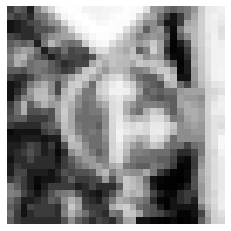

In [14]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)

plt.imshow(img, cmap=plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

### Preprocessing function

In [15]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  img = img.reshape(32, 32, 1)
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

## First Attempt: Using LeNet Architecture
Trying to use the same architecture as the one we used for the mnist dataset

In [17]:
np.random.seed(1)

def leNet_model():
  model = Sequential()
  model.add(Conv2D(30, (5,5), input_shape=(32, 32, 1) , activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15, (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(500, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation="softmax"))
  model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = leNet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 540)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               270500    
_________________________________________________________________
dropout (Dropout)            (None, 500)               0

In [18]:
history = model.fit(x=X_train, y=y_train, batch_size=200, epochs=20, verbose=1, validation_data=(X_val, y_val), shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 4s 107us/sample - loss: 1.6333 - accuracy: 0.5320 - val_loss: 0.7693 - val_accuracy: 0.7796
Epoch 2/20
34799/34799 [==============================] - 1s 30us/sample - loss: 0.5967 - accuracy: 0.8111 - val_loss: 0.5280 - val_accuracy: 0.8465
Epoch 3/20
34799/34799 [==============================] - 1s 30us/sample - loss: 0.4278 - accuracy: 0.8626 - val_loss: 0.4248 - val_accuracy: 0.8859
Epoch 4/20
34799/34799 [==============================] - 1s 30us/sample - loss: 0.3563 - accuracy: 0.8862 - val_loss: 0.4157 - val_accuracy: 0.8859
Epoch 5/20
34799/34799 [==============================] - 1s 30us/sample - loss: 0.3154 - accuracy: 0.9007 - val_loss: 0.4172 - val_accuracy: 0.8798
Epoch 6/20
34799/34799 [==============================] - 1s 29us/sample - loss: 0.2807 - accuracy: 0.9110 - val_loss: 0.4901 - val_accuracy: 0.8717
Epoch 7/20
34799/34799 [==============================] 

Text(0.5, 0, 'epoch')

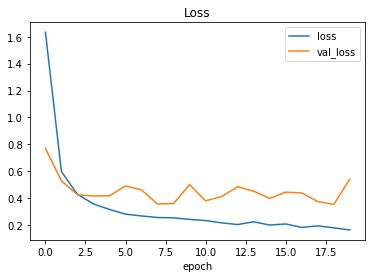

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

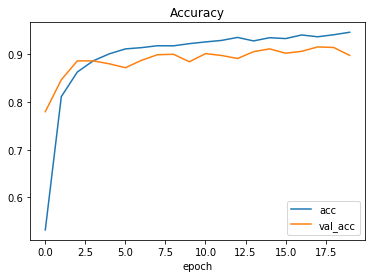

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

### Accuracy of our model on test data

It seems to be performing quite poorly, at a 89.1% accuracy on our test data.

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test score: {score[0] * 100 : .3f}%")
print(f"Test accuracy: {score[1] * 100 : .3f}%")

Test score:  67.071%
Test accuracy:  89.153%


### Testing our model on real data

In [0]:
import requests
import PIL.Image
def get_processed_img(img_url):
  response = requests.get(img_url, stream=True)
  img = PIL.Image.open(response.raw)
  img = np.asarray(img)
  img = cv2.resize(img, (32,32))
  plt.imshow(img)
  plt.axis("off")
  img = preprocessing(img)
  img = img.reshape(1, 32, 32, 1)
  return img

def get_prediction(img_url):
  img = get_processed_img(img_url)
  prediction = model.predict_classes(img)
  predicted_class = data["SignName"][prediction[0]]
  print(f"Predicted traffic sign: {predicted_class}")



Predicted traffic sign: Priority road


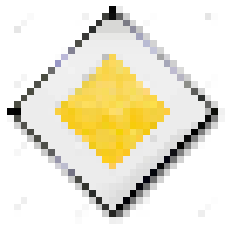

In [23]:
get_prediction("https://previews.123rf.com/images/upixel123/upixel1231205/upixel123120500086/13764164-traffic-sign-right-of-way.jpg")

Predicted traffic sign: Stop


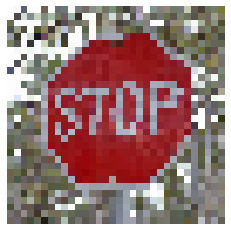

In [24]:
get_prediction("https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/1200px-STOP_sign.jpg")

Predicted traffic sign: Road work


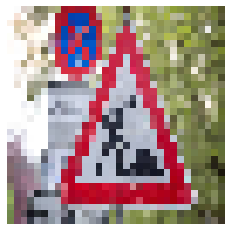

In [25]:
get_prediction("https://previews.123rf.com/images/teka77/teka771405/teka77140500244/28816204-german-construction-site-sign.jpg")